<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [GTSRB2] - First convolutions
<!-- DESC --> Episode 2 : First convolutions and first classification of our traffic signs
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
  - Recognizing traffic signs 
  - Understand the **principles** and **architecture** of a **convolutional neural network** for image classification
  
The German Traffic Sign Recognition Benchmark (GTSRB) is a dataset with more than 50,000 photos of road signs from about 40 classes.  
The final aim is to recognise them !  

Description is available there : http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset


**IMPORTANT :** To be able to use this notebook and the following, **you must have generated the enhanced datasets** in <dataset_dir>/enhanced via the notebook **[01-Preparation-of-data.ipynb](01-Preparation-of-data.ipynb)**  

## What we're going to do :

 - Read H5 dataset
 - Build a model
 - Train the model
 - Evaluate the model

## Step 1 - Import and init
### 1.1 - Python stuff

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import matplotlib.pyplot as plt
import h5py
import os,time,sys

from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/GTSRB2.001'
datasets_dir = pwk.init('GTSRB2', run_dir)

**\*\* Overrided parameters : \*\***

run_dir              : ./run/GTSRB2_done


<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.12
Notebook id          : GTSRB2
Run time             : Tuesday 09 February 2021, 18:45:06
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run/GTSRB2_done
Update keras cache   : False
Save figs            : True
Path figs            : ./run/GTSRB2_done/figs


### 1.2 - Parameters
`scale` is the proportion of the dataset that will be used during the training. (1 mean 100%)  
A 24x24 dataset, with 5 epochs and a scale of 1, need  **3'30** on a CPU laptop.

In [2]:
enhanced_dir = f'{datasets_dir}/GTSRB/enhanced'
dataset_name = 'set-24x24-L'
batch_size   = 64
epochs       = 5
scale        = 1

# enhanced_dir = './data'

Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('enhanced_dir', 'dataset_name', 'batch_size', 'epochs', 'scale')

**\*\* Overrided parameters : \*\***

enhanced_dir         : /gpfswork/rech/mlh/uja62cb/datasets/GTSRB/enhanced
dataset_name         : set-24x24-L
batch_size           : 64
epochs               : 5
scale                : 1


## Step 2 - Load dataset
We're going to retrieve a previously recorded dataset.  
For example: set-24x24-L

In [4]:
def read_dataset(enhanced_dir, dataset_name):
    '''Reads h5 dataset
    Args:
        filename     : datasets filename
        dataset_name : dataset name, without .h5
    Returns:    x_train,y_train, x_test,y_test data, x_meta,y_meta'''
    # ---- Read dataset
    pwk.chrono_start()
    filename = f'{enhanced_dir}/{dataset_name}.h5'
    with  h5py.File(filename,'r') as f:
        x_train = f['x_train'][:]
        y_train = f['y_train'][:]
        x_test  = f['x_test'][:]
        y_test  = f['y_test'][:]
        x_meta  = f['x_meta'][:]
        y_meta  = f['y_meta'][:]
    print(x_train.shape, y_train.shape)
    # ---- Shuffle
    x_train,y_train=pwk.shuffle_np_dataset(x_train,y_train)

    # ---- done
    duration = pwk.chrono_stop(hdelay=True)
    size     = pwk.hsize(os.path.getsize(filename))
    print(f'Dataset "{dataset_name}" is loaded and shuffled. ({size} in {duration})')
    return x_train,y_train, x_test,y_test, x_meta,y_meta

# ---- Read dataset
#
x_train,y_train,x_test,y_test, x_meta,y_meta = read_dataset(enhanced_dir, dataset_name)

# ---- Rescale 
#
x_train,y_train, x_test,y_test = pwk.rescale_dataset(x_train,y_train,x_test,y_test, scale=scale)

(39209, 24, 24, 1) (39209,)


Dataset "set-24x24-L" is loaded and shuffled. (228.8 Mo in 00:00:01 941ms)


## Step 3 - Have a look to the dataset
We take a quick look as we go by...

x_train :  (39209, 24, 24, 1)
y_train :  (39209,)
x_test  :  (12630, 24, 24, 1)
y_test  :  (12630,)


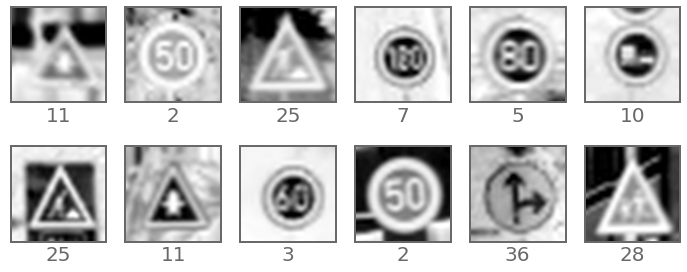

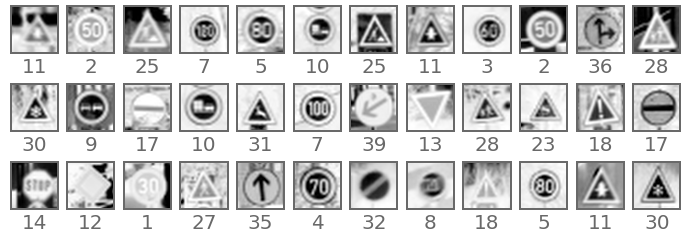

In [5]:
print("x_train : ", x_train.shape)
print("y_train : ", y_train.shape)
print("x_test  : ", x_test.shape)
print("y_test  : ", y_test.shape)

pwk.plot_images(x_train, y_train, range(12), columns=6,  x_size=2, y_size=2, save_as='01-dataset-medium')
pwk.plot_images(x_train, y_train, range(36), columns=12, x_size=1, y_size=1, save_as='02-dataset-small')

## Step 4 - Create model
We will now build a model and train it...

Some models :

In [6]:

# A basic model
#
def get_model_v1(lx,ly,lz):
    
    model = keras.models.Sequential()
    
    model.add( keras.layers.Conv2D(96, (3,3), activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(192, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1500, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model
    
# A more sophisticated model
#
def get_model_v2(lx,ly,lz):
    model = keras.models.Sequential()

    model.add( keras.layers.Conv2D(64, (3, 3), padding='same', input_shape=(lx,ly,lz), activation='relu'))
    model.add( keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add( keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(256, (3, 3), padding='same',activation='relu'))
    model.add( keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten())
    model.add( keras.layers.Dense(512, activation='relu'))
    model.add( keras.layers.Dropout(0.5))
    model.add( keras.layers.Dense(43, activation='softmax'))
    return model

# My sphisticated model, but small and fast
#
def get_model_v3(lx,ly,lz):
    model = keras.models.Sequential()
    model.add( keras.layers.Conv2D(32, (3,3),   activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1152, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model


## Step 5 - Train the model
**Get the shape of my data :**

In [7]:
(n,lx,ly,lz) = x_train.shape
print("Images of the dataset have this folowing shape : ",(lx,ly,lz))

Images of the dataset have this folowing shape :  (24, 24, 1)


**Get and compile a model, with the data shape :**

In [8]:
model = get_model_v1(lx,ly,lz)

model.summary()

model.compile(optimizer = 'adam',
              loss      = 'sparse_categorical_crossentropy',
              metrics   = ['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 22, 22, 96)        960       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 192)         166080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 192)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 192)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0

**Train it :**

In [9]:
pwk.chrono_start()

# ---- Shuffle train data
x_train,y_train=pwk.shuffle_np_dataset(x_train,y_train)

# ---- Train
history = model.fit(  x_train, y_train,
                      batch_size      = batch_size,
                      epochs          = epochs,
                      verbose         = 1,
                      validation_data = (x_test, y_test))

pwk.chrono_show()

Epoch 1/5


  1/613 [..............................] - ETA: 1:30:15 - loss: 3.7644 - accuracy: 0.0312

 20/613 [..............................] - ETA: 1s - loss: 3.6290 - accuracy: 0.0568     

 40/613 [>.............................] - ETA: 1s - loss: 3.5865 - accuracy: 0.0603

 60/613 [=>............................] - ETA: 1s - loss: 3.5572 - accuracy: 0.0667

 81/613 [==>...........................] - ETA: 1s - loss: 3.5233 - accuracy: 0.0751

102/613 [===>..........................] - ETA: 1s - loss: 3.4797 - accuracy: 0.0877

122/613 [====>.........................] - ETA: 1s - loss: 3.4259 - accuracy: 0.1027

142/613 [=====>........................] - ETA: 1s - loss: 3.3634 - accuracy: 0.1191

163/613 [======>.......................] - ETA: 1s - loss: 3.2914 - accuracy: 0.1374

183/613 [=======>......................] - ETA: 1s - loss: 3.2206 - accuracy: 0.1552

203/613 [========>.....................] - ETA: 1s - loss: 3.1498 - accuracy: 0.1729

224/613 [=========>....................] - ETA: 0s - loss: 3.0767 - accuracy: 0.1911

245/613 [==========>...................] - ETA: 0s - loss: 3.0056 - accuracy: 0.2088

265/613 [===========>..................] - ETA: 0s - loss: 2.9404 - accuracy: 0.2250

286/613 [============>.................] - ETA: 0s - loss: 2.8748 - accuracy: 0.2413

306/613 [=============>................] - ETA: 0s - loss: 2.8151 - accuracy: 0.2562

326/613 [==============>...............] - ETA: 0s - loss: 2.7579 - accuracy: 0.2705

347/613 [===============>..............] - ETA: 0s - loss: 2.7006 - accuracy: 0.2849

367/613 [================>.............] - ETA: 0s - loss: 2.6482 - accuracy: 0.2981

387/613 [=================>............] - ETA: 0s - loss: 2.5982 - accuracy: 0.3107

407/613 [==================>...........] - ETA: 0s - loss: 2.5503 - accuracy: 0.3228

428/613 [===================>..........] - ETA: 0s - loss: 2.5023 - accuracy: 0.3350

448/613 [====================>.........] - ETA: 0s - loss: 2.4585 - accuracy: 0.3462

468/613 [=====================>........] - ETA: 0s - loss: 2.4165 - accuracy: 0.3569

488/613 [======================>.......] - ETA: 0s - loss: 2.3763 - accuracy: 0.3671

509/613 [=======================>......] - ETA: 0s - loss: 2.3357 - accuracy: 0.3775

530/613 [========================>.....] - ETA: 0s - loss: 2.2966 - accuracy: 0.3876

550/613 [=========================>....] - ETA: 0s - loss: 2.2609 - accuracy: 0.3968

570/613 [==========================>...] - ETA: 0s - loss: 2.2265 - accuracy: 0.4057

590/613 [===========================>..] - ETA: 0s - loss: 2.1933 - accuracy: 0.4142

610/613 [============================>.] - ETA: 0s - loss: 2.1614 - accuracy: 0.4224

613/613 [==============================] - 12s 4ms/step - loss: 2.1552 - accuracy: 0.4240 - val_loss: 0.4526 - val_accuracy: 0.8880


Epoch 2/5
  1/613 [..............................] - ETA: 1s - loss: 0.2968 - accuracy: 0.9375

 21/613 [>.............................] - ETA: 1s - loss: 0.2917 - accuracy: 0.9139

 41/613 [=>............................] - ETA: 1s - loss: 0.2939 - accuracy: 0.9141

 61/613 [=>............................] - ETA: 1s - loss: 0.2923 - accuracy: 0.9149

 82/613 [===>..........................] - ETA: 1s - loss: 0.2911 - accuracy: 0.9152

103/613 [====>.........................] - ETA: 1s - loss: 0.2897 - accuracy: 0.9153

123/613 [=====>........................] - ETA: 1s - loss: 0.2882 - accuracy: 0.9158

143/613 [=====>........................] - ETA: 1s - loss: 0.2872 - accuracy: 0.9161

163/613 [======>.......................] - ETA: 1s - loss: 0.2862 - accuracy: 0.9164

183/613 [=======>......................] - ETA: 1s - loss: 0.2850 - accuracy: 0.9168

203/613 [========>.....................] - ETA: 1s - loss: 0.2835 - accuracy: 0.9172

223/613 [=========>....................] - ETA: 0s - loss: 0.2822 - accuracy: 0.9177

243/613 [==========>...................] - ETA: 0s - loss: 0.2808 - accuracy: 0.9181

263/613 [===========>..................] - ETA: 0s - loss: 0.2794 - accuracy: 0.9186

283/613 [============>.................] - ETA: 0s - loss: 0.2780 - accuracy: 0.9191

303/613 [=============>................] - ETA: 0s - loss: 0.2766 - accuracy: 0.9195

323/613 [==============>...............] - ETA: 0s - loss: 0.2753 - accuracy: 0.9200

343/613 [===============>..............] - ETA: 0s - loss: 0.2740 - accuracy: 0.9204

363/613 [================>.............] - ETA: 0s - loss: 0.2728 - accuracy: 0.9207

383/613 [=================>............] - ETA: 0s - loss: 0.2716 - accuracy: 0.9211

403/613 [==================>...........] - ETA: 0s - loss: 0.2705 - accuracy: 0.9214

423/613 [===================>..........] - ETA: 0s - loss: 0.2694 - accuracy: 0.9218

443/613 [====================>.........] - ETA: 0s - loss: 0.2682 - accuracy: 0.9221

463/613 [=====================>........] - ETA: 0s - loss: 0.2671 - accuracy: 0.9225

483/613 [======================>.......] - ETA: 0s - loss: 0.2659 - accuracy: 0.9228

504/613 [=======================>......] - ETA: 0s - loss: 0.2647 - accuracy: 0.9232

524/613 [========================>.....] - ETA: 0s - loss: 0.2635 - accuracy: 0.9236

544/613 [=========================>....] - ETA: 0s - loss: 0.2623 - accuracy: 0.9239

564/613 [==========================>...] - ETA: 0s - loss: 0.2611 - accuracy: 0.9243

584/613 [===========================>..] - ETA: 0s - loss: 0.2600 - accuracy: 0.9246

604/613 [============================>.] - ETA: 0s - loss: 0.2589 - accuracy: 0.9249

613/613 [==============================] - 2s 3ms/step - loss: 0.2583 - accuracy: 0.9251 - val_loss: 0.3315 - val_accuracy: 0.9215


Epoch 3/5
  1/613 [..............................] - ETA: 1s - loss: 0.1627 - accuracy: 0.9688

 21/613 [>.............................] - ETA: 1s - loss: 0.1607 - accuracy: 0.9529

 41/613 [=>............................] - ETA: 1s - loss: 0.1488 - accuracy: 0.9578

 61/613 [=>............................] - ETA: 1s - loss: 0.1459 - accuracy: 0.9593

 81/613 [==>...........................] - ETA: 1s - loss: 0.1443 - accuracy: 0.9596

101/613 [===>..........................] - ETA: 1s - loss: 0.1427 - accuracy: 0.9598

121/613 [====>.........................] - ETA: 1s - loss: 0.1422 - accuracy: 0.9598

141/613 [=====>........................] - ETA: 1s - loss: 0.1421 - accuracy: 0.9597

161/613 [======>.......................] - ETA: 1s - loss: 0.1423 - accuracy: 0.9594

181/613 [=======>......................] - ETA: 1s - loss: 0.1426 - accuracy: 0.9592

201/613 [========>.....................] - ETA: 1s - loss: 0.1427 - accuracy: 0.9589

221/613 [=========>....................] - ETA: 0s - loss: 0.1428 - accuracy: 0.9588

241/613 [==========>...................] - ETA: 0s - loss: 0.1427 - accuracy: 0.9587

261/613 [===========>..................] - ETA: 0s - loss: 0.1424 - accuracy: 0.9587

281/613 [============>.................] - ETA: 0s - loss: 0.1420 - accuracy: 0.9588

301/613 [=============>................] - ETA: 0s - loss: 0.1416 - accuracy: 0.9589

321/613 [==============>...............] - ETA: 0s - loss: 0.1413 - accuracy: 0.9589

341/613 [===============>..............] - ETA: 0s - loss: 0.1409 - accuracy: 0.9590

361/613 [================>.............] - ETA: 0s - loss: 0.1405 - accuracy: 0.9591

381/613 [=================>............] - ETA: 0s - loss: 0.1401 - accuracy: 0.9592

401/613 [==================>...........] - ETA: 0s - loss: 0.1398 - accuracy: 0.9592

421/613 [===================>..........] - ETA: 0s - loss: 0.1395 - accuracy: 0.9593

441/613 [====================>.........] - ETA: 0s - loss: 0.1391 - accuracy: 0.9594

461/613 [=====================>........] - ETA: 0s - loss: 0.1388 - accuracy: 0.9595

481/613 [======================>.......] - ETA: 0s - loss: 0.1385 - accuracy: 0.9596

501/613 [=======================>......] - ETA: 0s - loss: 0.1381 - accuracy: 0.9597

521/613 [========================>.....] - ETA: 0s - loss: 0.1378 - accuracy: 0.9597

541/613 [=========================>....] - ETA: 0s - loss: 0.1375 - accuracy: 0.9598

561/613 [==========================>...] - ETA: 0s - loss: 0.1372 - accuracy: 0.9599

582/613 [===========================>..] - ETA: 0s - loss: 0.1369 - accuracy: 0.9600

602/613 [============================>.] - ETA: 0s - loss: 0.1366 - accuracy: 0.9601

613/613 [==============================] - 2s 3ms/step - loss: 0.1364 - accuracy: 0.9601 - val_loss: 0.2702 - val_accuracy: 0.9369


Epoch 4/5
  1/613 [..............................] - ETA: 1s - loss: 0.1057 - accuracy: 0.9844

 21/613 [>.............................] - ETA: 1s - loss: 0.0761 - accuracy: 0.9827

 41/613 [=>............................] - ETA: 1s - loss: 0.0764 - accuracy: 0.9806

 61/613 [=>............................] - ETA: 1s - loss: 0.0770 - accuracy: 0.9799

 81/613 [==>...........................] - ETA: 1s - loss: 0.0778 - accuracy: 0.9794

101/613 [===>..........................] - ETA: 1s - loss: 0.0783 - accuracy: 0.9790

121/613 [====>.........................] - ETA: 1s - loss: 0.0788 - accuracy: 0.9787

141/613 [=====>........................] - ETA: 1s - loss: 0.0795 - accuracy: 0.9786

161/613 [======>.......................] - ETA: 1s - loss: 0.0802 - accuracy: 0.9785

182/613 [=======>......................] - ETA: 1s - loss: 0.0806 - accuracy: 0.9784

202/613 [========>.....................] - ETA: 1s - loss: 0.0809 - accuracy: 0.9783

222/613 [=========>....................] - ETA: 0s - loss: 0.0812 - accuracy: 0.9782

242/613 [==========>...................] - ETA: 0s - loss: 0.0816 - accuracy: 0.9780

263/613 [===========>..................] - ETA: 0s - loss: 0.0819 - accuracy: 0.9779

283/613 [============>.................] - ETA: 0s - loss: 0.0821 - accuracy: 0.9778

304/613 [=============>................] - ETA: 0s - loss: 0.0823 - accuracy: 0.9777

324/613 [==============>...............] - ETA: 0s - loss: 0.0825 - accuracy: 0.9776

344/613 [===============>..............] - ETA: 0s - loss: 0.0828 - accuracy: 0.9775

365/613 [================>.............] - ETA: 0s - loss: 0.0830 - accuracy: 0.9774

385/613 [=================>............] - ETA: 0s - loss: 0.0832 - accuracy: 0.9773

405/613 [==================>...........] - ETA: 0s - loss: 0.0833 - accuracy: 0.9773

425/613 [===================>..........] - ETA: 0s - loss: 0.0834 - accuracy: 0.9772

445/613 [====================>.........] - ETA: 0s - loss: 0.0836 - accuracy: 0.9771

465/613 [=====================>........] - ETA: 0s - loss: 0.0837 - accuracy: 0.9770

485/613 [======================>.......] - ETA: 0s - loss: 0.0838 - accuracy: 0.9770

505/613 [=======================>......] - ETA: 0s - loss: 0.0838 - accuracy: 0.9769

525/613 [========================>.....] - ETA: 0s - loss: 0.0839 - accuracy: 0.9768

545/613 [=========================>....] - ETA: 0s - loss: 0.0840 - accuracy: 0.9768

565/613 [==========================>...] - ETA: 0s - loss: 0.0840 - accuracy: 0.9768

585/613 [===========================>..] - ETA: 0s - loss: 0.0841 - accuracy: 0.9767

606/613 [============================>.] - ETA: 0s - loss: 0.0841 - accuracy: 0.9767

613/613 [==============================] - 2s 3ms/step - loss: 0.0841 - accuracy: 0.9767 - val_loss: 0.2508 - val_accuracy: 0.9417


Epoch 5/5
  1/613 [..............................] - ETA: 1s - loss: 0.0494 - accuracy: 0.9844

 21/613 [>.............................] - ETA: 1s - loss: 0.0656 - accuracy: 0.9830

 41/613 [=>............................] - ETA: 1s - loss: 0.0704 - accuracy: 0.9811

 61/613 [=>............................] - ETA: 1s - loss: 0.0728 - accuracy: 0.9792

 81/613 [==>...........................] - ETA: 1s - loss: 0.0746 - accuracy: 0.9780

101/613 [===>..........................] - ETA: 1s - loss: 0.0748 - accuracy: 0.9776

121/613 [====>.........................] - ETA: 1s - loss: 0.0745 - accuracy: 0.9776

141/613 [=====>........................] - ETA: 1s - loss: 0.0745 - accuracy: 0.9775

161/613 [======>.......................] - ETA: 1s - loss: 0.0743 - accuracy: 0.9775

181/613 [=======>......................] - ETA: 1s - loss: 0.0741 - accuracy: 0.9775

201/613 [========>.....................] - ETA: 1s - loss: 0.0738 - accuracy: 0.9776

221/613 [=========>....................] - ETA: 0s - loss: 0.0734 - accuracy: 0.9777

241/613 [==========>...................] - ETA: 0s - loss: 0.0730 - accuracy: 0.9779

261/613 [===========>..................] - ETA: 0s - loss: 0.0727 - accuracy: 0.9780

281/613 [============>.................] - ETA: 0s - loss: 0.0724 - accuracy: 0.9781

301/613 [=============>................] - ETA: 0s - loss: 0.0722 - accuracy: 0.9781

321/613 [==============>...............] - ETA: 0s - loss: 0.0721 - accuracy: 0.9782

341/613 [===============>..............] - ETA: 0s - loss: 0.0721 - accuracy: 0.9782

361/613 [================>.............] - ETA: 0s - loss: 0.0720 - accuracy: 0.9782

381/613 [=================>............] - ETA: 0s - loss: 0.0719 - accuracy: 0.9782

401/613 [==================>...........] - ETA: 0s - loss: 0.0718 - accuracy: 0.9782

421/613 [===================>..........] - ETA: 0s - loss: 0.0718 - accuracy: 0.9782

441/613 [====================>.........] - ETA: 0s - loss: 0.0717 - accuracy: 0.9782

461/613 [=====================>........] - ETA: 0s - loss: 0.0717 - accuracy: 0.9782

481/613 [======================>.......] - ETA: 0s - loss: 0.0717 - accuracy: 0.9782

501/613 [=======================>......] - ETA: 0s - loss: 0.0717 - accuracy: 0.9782

521/613 [========================>.....] - ETA: 0s - loss: 0.0717 - accuracy: 0.9782

541/613 [=========================>....] - ETA: 0s - loss: 0.0717 - accuracy: 0.9782

561/613 [==========================>...] - ETA: 0s - loss: 0.0717 - accuracy: 0.9782

581/613 [===========================>..] - ETA: 0s - loss: 0.0717 - accuracy: 0.9782

601/613 [============================>.] - ETA: 0s - loss: 0.0717 - accuracy: 0.9782

613/613 [==============================] - 2s 3ms/step - loss: 0.0717 - accuracy: 0.9782 - val_loss: 0.2265 - val_accuracy: 0.9486



Duration :  00:00:19 217ms


**Evaluate it :**

In [10]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.9486


In [11]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.2265
Test accuracy  : 0.9486


In [12]:
pwk.end()

End time is : Tuesday 09 February 2021, 18:45:35
Duration is : 00:00:29 151ms
This notebook ends here


<div class="todo">
    What you can do:
    <ul>
        <li>Try the different models</li>
        <li>Try with different datasets</li>
        <li>Test different hyperparameters (epochs, batch size, optimization, etc.)</li>
        <li>Create your own model</li>
    </ul>
</div>

---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>